In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import os

In [2]:
patient_data=pd.read_csv('./input/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])

In [3]:
patient_data.head()

pid  disease
0  101     URTI
1  102  Healthy
2  103   Asthma
3  104     COPD
4  105     URTI

In [4]:
df=pd.read_csv('./input/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/160_1b3_Al_mc_AKGC417L.txt',sep='\t')
df.head()

1.862   5.718  0  1
0   5.718   9.725  1  1
1   9.725  13.614  0  1
2  13.614  17.671  0  1
3  17.671  19.541  0  0

In [5]:
import os
path='./input/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

['101_1b1_Al_sc_Meditron',
 '101_1b1_Pr_sc_Meditron',
 '102_1b1_Ar_sc_Meditron',
 '103_2b2_Ar_mc_LittC2SE',
 '104_1b1_Al_sc_Litt3200']

In [6]:
def getFilenameInfo(file):
    return file.split('_')
getFilenameInfo('160_1b3_Al_mc_AKGC417L')

['160', '1b3', 'Al', 'mc', 'AKGC417L']

In [7]:
files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt',sep='\t',names=['start','end','crackles','weezels'])
    name_data=getFilenameInfo(file)
    data['pid']=name_data[0]
    data['mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)
files_df.reset_index()
files_df.head()

start    end  crackles  weezels  pid mode                filename
0  0.036  0.579         0        0  101   sc  101_1b1_Al_sc_Meditron
1  0.579  2.450         0        0  101   sc  101_1b1_Al_sc_Meditron
2  2.450  3.893         0        0  101   sc  101_1b1_Al_sc_Meditron
3  3.893  5.793         0        0  101   sc  101_1b1_Al_sc_Meditron
4  5.793  7.521         0        0  101   sc  101_1b1_Al_sc_Meditron

In [8]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pid      126 non-null    int64 
 1   disease  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [9]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 10
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   weezels   6898 non-null   int64  
 4   pid       6898 non-null   object 
 5   mode      6898 non-null   object 
 6   filename  6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


In [10]:
patient_data.pid=patient_data.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')
data=pd.merge(files_df,patient_data,on='pid')
data.head()

start    end  crackles  weezels  pid mode                filename disease
0  0.036  0.579         0        0  101   sc  101_1b1_Al_sc_Meditron    URTI
1  0.579  2.450         0        0  101   sc  101_1b1_Al_sc_Meditron    URTI
2  2.450  3.893         0        0  101   sc  101_1b1_Al_sc_Meditron    URTI
3  3.893  5.793         0        0  101   sc  101_1b1_Al_sc_Meditron    URTI
4  5.793  7.521         0        0  101   sc  101_1b1_Al_sc_Meditron    URTI

In [11]:
os.makedirs('csv_data')
data.to_csv('csv_data/data.csv',index=False)

FileExistsError: [WinError 183] 파일이 이미 있으므로 만들 수 없습니다: 'csv_data'

In [12]:
def getPureSample(raw_data,start,end,sr=22050):
    '''
    Takes a numpy array and spilts its using start and end args
    
    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    
    '''
    max_ind = len(raw_data) 
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

<AxesSubplot:ylabel='pid'>

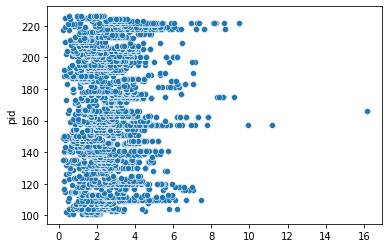

In [13]:
sns.scatterplot(x=(data.end-data.start), y=data.pid)

<AxesSubplot:>

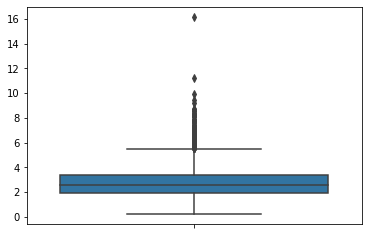

In [14]:
sns.boxplot(y=(data.end-data.start))

From these plots we can conclude that best length is ~6

Also if difference is <6 we must Zero Pad it to get it to required length

Zero Padding means silent

In [17]:
os.makedirs('processed_audio_files')

In [15]:
for index,row in data.iterrows():
    print("Index ->",index)
    print("Data->\n",row)
    break

Index -> 0
Data->
 start                        0.036
end                          0.579
crackles                         0
weezels                          0
pid                            101
mode                            sc
filename    101_1b1_Al_sc_Meditron
disease                       URTI
Name: 0, dtype: object


In [ ]:
import librosa as lb
import soundfile as sf
i,c=0,0
for index,row in data.iterrows():
    maxLen=6
    start=row['start']
    end=row['end']
    filename=row['filename']
    
    #If len > maxLen , change it to maxLen
    if end-start>maxLen:
        end=start+maxLen
    
    audio_file_loc=path + filename + '.wav'
    
    if index > 0:
        #check if more cycles exits for same patient if so then add i to change filename
        if data.iloc[index-1]['filename']==filename:
            i+=1
        else:
            i=0
    filename= filename + '_' + str(i) + '.wav'
    
    save_path='processed_audio_files/' + filename
    c+=1
    
    audioArr,sampleRate=lb.load(audio_file_loc)
    pureSample=getPureSample(audioArr,start,end,sampleRate)
    
    #pad audio if pureSample len < max_len
    reqLen=6*sampleRate
    padded_data = lb.util.pad_center(pureSample,reqLen)
    
    sf.write(file=save_path,data=padded_data,samplerate=sampleRate)
print('Total Files Processed: ',c)

<ipython-input-16-b1cc7c95835c>:32: FutureWarning: Pass size=132300 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  padded_data = lb.util.pad_center(pureSample,reqLen)


In [ ]:
diagnosis=pd.read_csv('./input/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])
diagnosis.head()

In [ ]:
sns.countplot(diagnosis.disease)
plt.xticks(rotation=90)

In [28]:
import os
def extractId(filename):
    return filename.split('_')[0]

In [29]:
path='./processed_audio_files/'
length=len(os.listdir(path))
index=range(length)
i=0
files_df=pd.DataFrame(index=index,columns=['pid','filename'])
for f in os.listdir(path):
    files_df.iloc[i]['pid']=extractId(f)
    files_df.iloc[i]['filename']=f
    i+=1
files_df.head()

pid                       filename
0  101   101_1b1_Al_sc_Meditron_0.wav
1  101   101_1b1_Al_sc_Meditron_1.wav
2  101  101_1b1_Al_sc_Meditron_10.wav
3  101  101_1b1_Al_sc_Meditron_11.wav
4  101   101_1b1_Al_sc_Meditron_2.wav

In [30]:
files_df.pid=files_df.pid.astype('int64') # both pid's must be of same dtype for them to merge

In [31]:
data=pd.merge(files_df,diagnosis,on='pid')
data.head()

pid                       filename disease
0  101   101_1b1_Al_sc_Meditron_0.wav    URTI
1  101   101_1b1_Al_sc_Meditron_1.wav    URTI
2  101  101_1b1_Al_sc_Meditron_10.wav    URTI
3  101  101_1b1_Al_sc_Meditron_11.wav    URTI
4  101   101_1b1_Al_sc_Meditron_2.wav    URTI

C:\Users\bkri3\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'URTI'),
  Text(1, 0, 'Healthy'),
  Text(2, 0, 'Asthma'),
  Text(3, 0, 'COPD'),
  Text(4, 0, 'LRTI'),
  Text(5, 0, 'Bronchiectasis'),
  Text(6, 0, 'Pneumonia'),
  Text(7, 0, 'Bronchiolitis')])

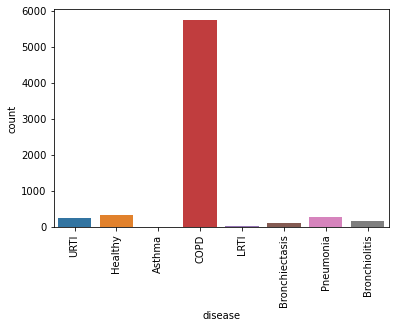

In [32]:
sns.countplot(data.disease)
plt.xticks(rotation=90)

In [2]:
from sklearn.model_selection import train_test_split
Xtrain,Xval,ytrain,yval=train_test_split(data,data.disease,stratify=data.disease,random_state=42,test_size=0.25)

NameError: name 'data' is not defined

In [34]:
Xtrain.disease.value_counts()/Xtrain.shape[0]

COPD              0.832979
Healthy           0.046588
Pneumonia         0.041369
URTI              0.035183
Bronchiolitis     0.023197
Bronchiectasis    0.015078
LRTI              0.004639
Asthma            0.000967
Name: disease, dtype: float64

In [35]:
Xval.disease.value_counts()/Xval.shape[0]

COPD              0.833043
Healthy           0.046957
Pneumonia         0.041159
URTI              0.035362
Bronchiolitis     0.023188
Bronchiectasis    0.015072
LRTI              0.004638
Asthma            0.000580
Name: disease, dtype: float64

In [1]:
path='./processed_audio_files/'

import librosa.display
file=path + Xtrain.iloc[101].filename 
sound,sample_rate=lb.load(file)
mfccs = lb.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40)
print( 'sampling rate: ', sample_rate)
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

NameError: name 'Xtrain' is not defined

In [37]:
Xtrain.to_csv('train.csv')
Xval.to_csv('val.csv')